<h1>K-Nearest Representatives Classifier<h1>

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from math import sqrt
%matplotlib inline

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.family'] = 'DejaVu Sans'

In [11]:
# First, let's load the CSV files to inspect the data and understand their structure.

import pandas as pd

# Load the datasets

# Load the data (assuming train_df, test_df, val_df have been loaded)
x_train = pd.read_csv('Dataset-3/train_data.csv')
y_train = pd.read_csv('Dataset-3/train_label.csv')
x_test = pd.read_csv('Dataset-3/test_data.csv')
y_test = pd.read_csv('Dataset-3/test_label.csv')
x_val = pd.read_csv('Dataset-3/val_data.csv')
y_val = pd.read_csv('Dataset-3/val_label.csv')

x_train = x_train.values
y_train = y_train.values.flatten()
x_test = x_test.values
y_test = y_test.values.flatten()
x_val = x_val.values
y_val = y_val.values.flatten()

In [12]:

from math import sqrt
# Function to compute Euclidean distance
def euclidean(a, b):
    return sqrt(np.sum((np.array(a) - np.array(b)) ** 2))
    
# Function to evaluate the accuracy of predictions
def evaluate_accuracy(y_true, y_pred):
    correct = np.sum(np.array(y_true) == np.array(y_pred))
    return correct / len(y_true)


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [13]:
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import confusion_matrix

# Function to get M representatives per class using KMeans
def get_representatives(x, y, M):
    representatives = []
    labels = []

    unique_classes = np.unique(y)
    
    for cls in unique_classes:
        class_points = x[y == cls]
        
        # Use KMeans to find M representatives for each class
        kmeans = KMeans(n_clusters=M, random_state=42)
        kmeans.fit(class_points)
        
        # Get the M cluster centers as representatives
        representatives.extend(kmeans.cluster_centers_)
        labels.extend([cls] * M)  # Assign the class label to each representative
    
    return np.array(representatives), np.array(labels)


In [14]:
# KNN-like classification function for representatives
def knr_classify(representatives, rep_labels, test_point, k):
    distances = []
    
    # Compute distance between the test point and each representative
    for i in range(len(representatives)):
        d = euclidean(representatives[i], test_point)
        distances.append((d, rep_labels[i]))
    
    # Sort by distance
    distances.sort(key=lambda x: x[0])
    
    # Take the k nearest representatives
    count = Counter()
    for i in distances[:k]:
        count[i[1]] += 1
    
    # Return the class with the highest vote (or break ties as before)
    max_count = count.most_common(1)[0][1]
    tied_classes = [key for key, value in count.items() if value == max_count]
    
    pred = tied_classes[0]
    
    if len(tied_classes) > 1:
        class_avg_dist = {}
        for cls in tied_classes:
            cls_distances = [d[0] for d in distances[:k] if d[1] == cls]
            class_avg_dist[cls] = np.mean(cls_distances)
        pred = min(class_avg_dist, key=class_avg_dist.get)
    
    return pred

# Function to predict using KNR for a dataset
def knr_predict(representatives, rep_labels, x_test, k):
    predictions = []
    for test_point in x_test:
        pred = knr_classify(representatives, rep_labels, test_point, k)
        predictions.append(pred)
    return predictions


In [15]:
# Function to evaluate performance and print accuracy and confusion matrix
def evaluate_classifier(y_true, y_pred, dataset_name):
    accuracy = evaluate_accuracy(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy on {dataset_name}: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix on {dataset_name}")
    
    return accuracy, cm


In [16]:
#Hyperparameters
M = 10  # Number of representatives per class
k_values = [1, 5, 9]

In [17]:
import pandas as pd

# Lists to store accuracies for different k values
Accuracyknr_train = []
Accuracyknr_val = []
Accuracyknr_test = []

# Get M representatives for each class from the training data
representatives, rep_labels = get_representatives(x_train, y_train, M)

print(f"\nEvaluating KNR for M={M}:")
# Loop through different K values and evaluate performance
for k in k_values:

    # Predict on training data
    train_predictions = knr_predict(representatives, rep_labels, x_train, k)
    train_accuracy = evaluate_accuracy(y_train, train_predictions)
    Accuracyknr_train.append(train_accuracy)

    # Predict on validation (CV) data
    val_predictions = knr_predict(representatives, rep_labels, x_val, k)
    val_accuracy = evaluate_accuracy(y_val, val_predictions)
    Accuracyknr_val.append(val_accuracy)

    # Predict on test data
    test_predictions = knr_predict(representatives, rep_labels, x_test, k)
    test_accuracy = evaluate_accuracy(y_test, test_predictions)
    Accuracyknr_test.append(test_accuracy)

# Create a DataFrame to store the accuracies for different k values
accuracy_table_KNR = pd.DataFrame(
    {
        "k-value": k_values,
        "Accuracy Train": Accuracyknr_train,
        "Accuracy Val": Accuracyknr_val,
        "Accuracy Test": Accuracyknr_test,
    }
)

# Display the accuracy table
print(accuracy_table_KNR)



Evaluating KNR for M=10:
   k-value  Accuracy Train  Accuracy Val  Accuracy Test
0        1        0.597427      0.384615       0.485810
1        5        0.501191      0.444816       0.479132
2        9        0.454502      0.481605       0.452421



Results for K=1:
Accuracy on Test Data K=1: 0.48580968280467446


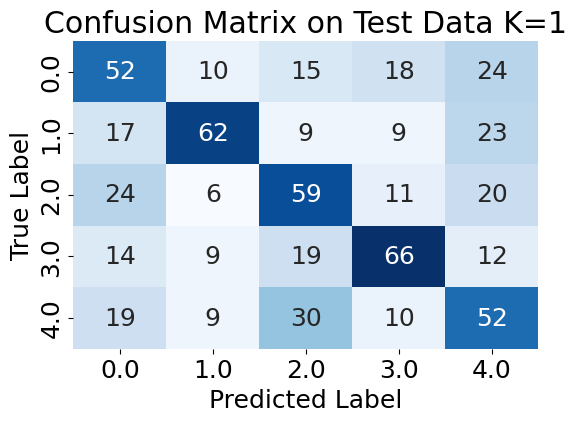

Accuracy on Validation Data K=1: 0.38461538461538464


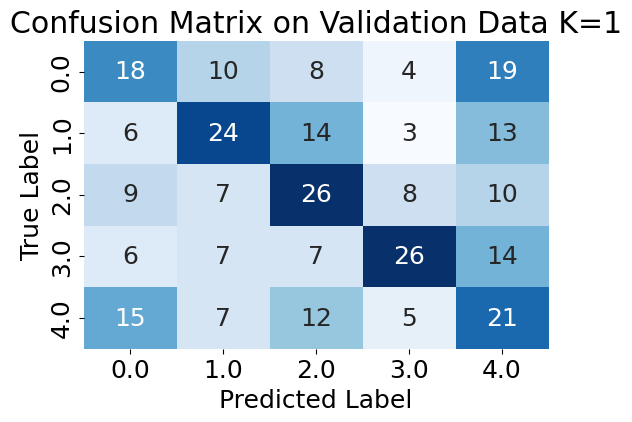

Accuracy on Train Data K=1: 0.5974273463554073


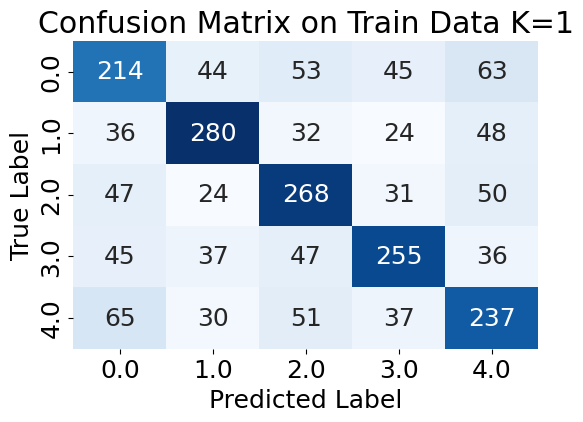


Results for K=5:
Accuracy on Test Data K=5: 0.4791318864774624


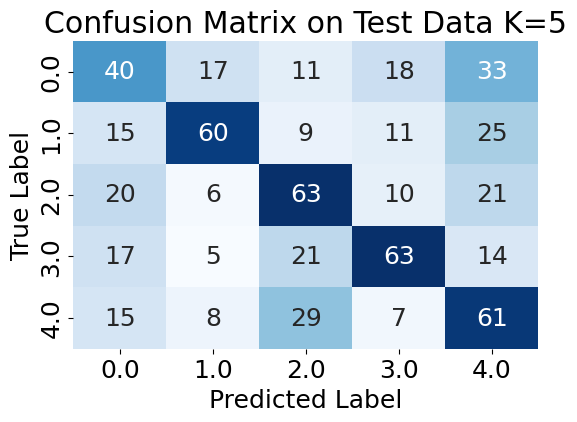

Accuracy on Validation Data K=5: 0.44481605351170567


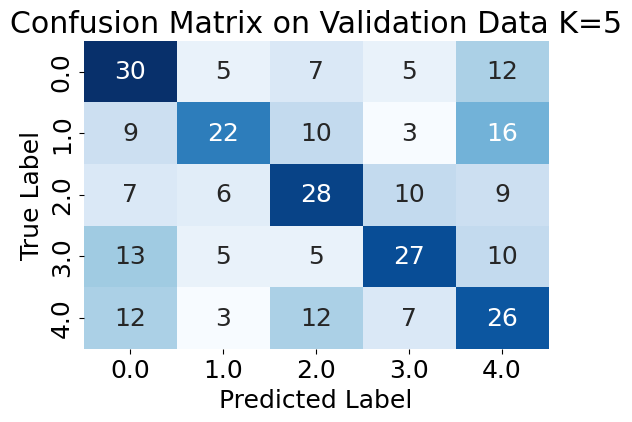

Accuracy on Train Data K=5: 0.5011910433539781


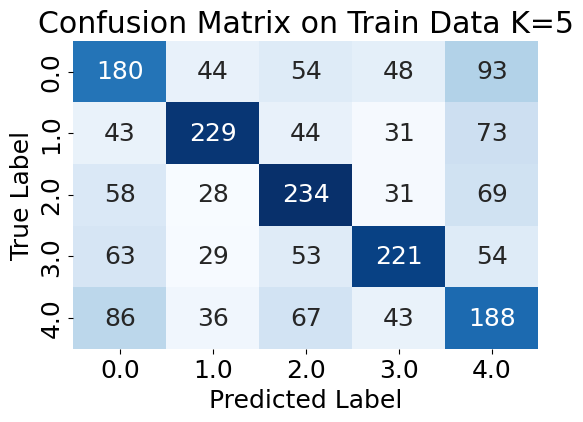


Results for K=9:
Accuracy on Test Data K=9: 0.4524207011686144


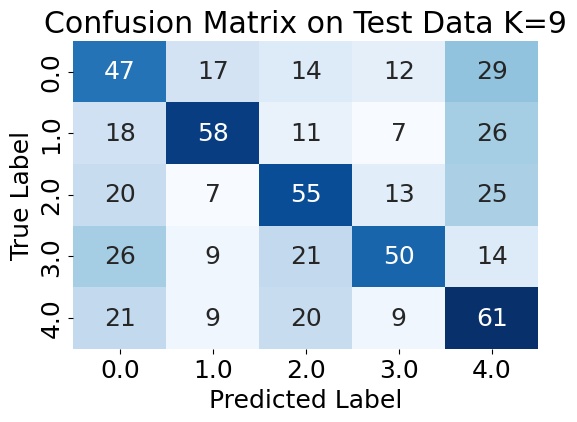

Accuracy on Validation Data K=9: 0.4816053511705686


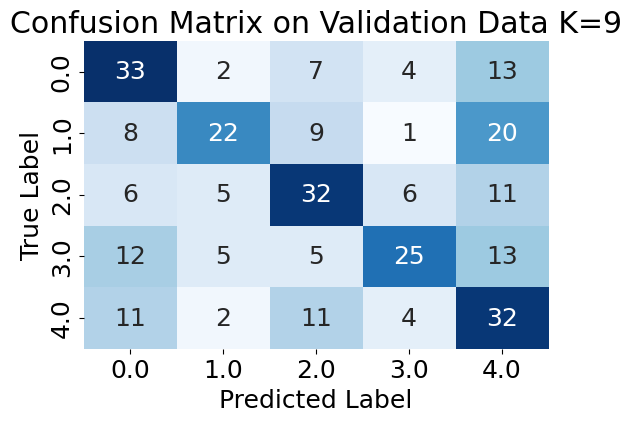

Accuracy on Train Data K=9: 0.45450214387803717


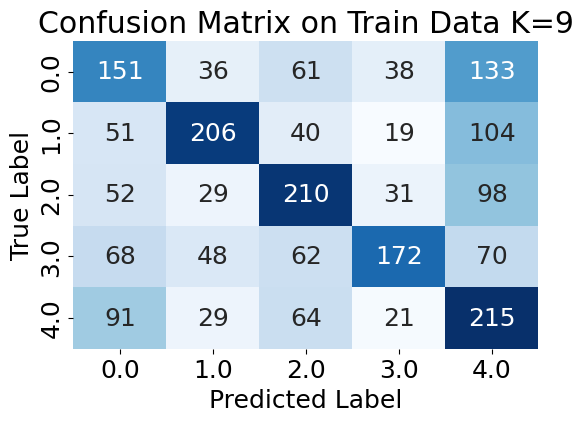

In [18]:
# Get M representatives for each class from the training data
representatives, rep_labels = get_representatives(x_train, y_train, M)

# Loop through different K values and evaluate performance
for k in k_values:
    print(f"\nResults for K={k}:")

    # Predict on test data
    test_predictions = knr_predict(representatives, rep_labels, x_test, k)
    evaluate_classifier(y_test, test_predictions, f"Test Data K={k}")

    # Predict on validation data
    val_predictions = knr_predict(representatives, rep_labels, x_val, k)
    evaluate_classifier(y_val, val_predictions, f"Validation Data K={k}")
    
    # Predict on Train data
    train_predictions = knr_predict(representatives, rep_labels, x_train, k)
    evaluate_classifier(y_train, train_predictions, f"Train Data K={k}")